In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [3]:
# Import dataset
data = pd.read_csv('/Users/kachunlee/Downloads/US_Accidents_Dec21_updated.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

In [5]:
# Convert Start_Time and End_Time 
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')



In [6]:
# Extract year, month, day, hour and weekday from start time
data['Year']=data['Start_Time'].dt.year
data['Month']=data['Start_Time'].dt.strftime('%b')
data['Day']=data['Start_Time'].dt.day
data['Hour']=data['Start_Time'].dt.hour
data['Weekday']=data['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
timedur='Time_Duration(min)'
data[timedur]=round((data['End_Time']-data['Start_Time'])/np.timedelta64(1,'m'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [9]:
#  deal with the outliers
#check if there is any negative time duration ,we dont want to see that 
data[timedur][data[timedur]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [10]:
#  droping the rows with timedur<0 
negative_outliers=data[timedur]<=0

# Set outliers to NAN
data[negative_outliers] = np.nan

# Drop rows with negative timedur
data.dropna(subset=[timedur],axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               float64       
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [11]:
# using median to fill na value
## using standard_deviation as 3  (n=3)

n=3

median = data[timedur].median()
std = data[timedur].std()
outliers = (data[timedur] - median).abs() > std*n

# Set outliers to NAN
data[outliers] = np.nan

# Fill NAN with median
data[timedur].fillna(median, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 53 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               float64       
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [12]:
##feature selection
feature_lst=['Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County',
             'State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 
             'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction'
             ,'No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal',
             'Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']


In [13]:
#check the selected features
data_feature=data[feature_lst].copy()
data_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845342 entries, 0 to 2845341
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Severity            float64
 1   Start_Lng           float64
 2   Start_Lat           float64
 3   Distance(mi)        float64
 4   Side                object 
 5   City                object 
 6   County              object 
 7   State               object 
 8   Timezone            object 
 9   Temperature(F)      float64
 10  Humidity(%)         float64
 11  Pressure(in)        float64
 12  Visibility(mi)      float64
 13  Wind_Direction      object 
 14  Weather_Condition   object 
 15  Amenity             object 
 16  Bump                object 
 17  Crossing            object 
 18  Give_Way            object 
 19  Junction            object 
 20  No_Exit             object 
 21  Railway             object 
 22  Roundabout          object 
 23  Station             object 
 24  Stop                obje

In [14]:
## double check if there is any missing value again
data_feature.isnull().mean()

Severity              0.000558
Start_Lng             0.000558
Start_Lat             0.000558
Distance(mi)          0.000558
Side                  0.000558
City                  0.000606
County                0.000558
State                 0.000558
Timezone              0.001843
Temperature(F)        0.024878
Humidity(%)           0.026220
Pressure(in)          0.021353
Visibility(mi)        0.025324
Wind_Direction        0.026458
Weather_Condition     0.025356
Amenity               0.000558
Bump                  0.000558
Crossing              0.000558
Give_Way              0.000558
Junction              0.000558
No_Exit               0.000558
Railway               0.000558
Roundabout            0.000558
Station               0.000558
Stop                  0.000558
Traffic_Calming       0.000558
Traffic_Signal        0.000558
Turning_Loop          0.000558
Sunrise_Sunset        0.001565
Hour                  0.000558
Weekday               0.000558
Time_Duration(min)    0.000000
dtype: f

In [15]:
data_feature.dropna(subset=data_feature.columns[data_feature.isnull().mean()!=0], how='any', axis=0, inplace=True)
data_feature.shape

(2732152, 32)

In [16]:
## only want to focus on MA state 
state='MA'
# Select the state of Massachusetts
df_state=data_feature.loc[data_feature.State==state].copy()
## drop state collumn since it is unnecessary anymore
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100 entries, 31631 to 2844947
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Severity            6100 non-null   float64
 1   Start_Lng           6100 non-null   float64
 2   Start_Lat           6100 non-null   float64
 3   Distance(mi)        6100 non-null   float64
 4   Side                6100 non-null   object 
 5   City                6100 non-null   object 
 6   County              6100 non-null   object 
 7   Timezone            6100 non-null   object 
 8   Temperature(F)      6100 non-null   float64
 9   Humidity(%)         6100 non-null   float64
 10  Pressure(in)        6100 non-null   float64
 11  Visibility(mi)      6100 non-null   float64
 12  Wind_Direction      6100 non-null   object 
 13  Weather_Condition   6100 non-null   object 
 14  Amenity             6100 non-null   object 
 15  Bump                6100 non-null   object 
 16 

# EDA 

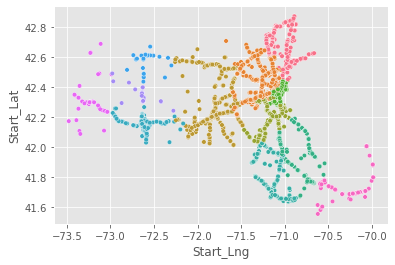

In [17]:
# Map of accidents by county ## need to run it in colab
import seaborn as sns
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

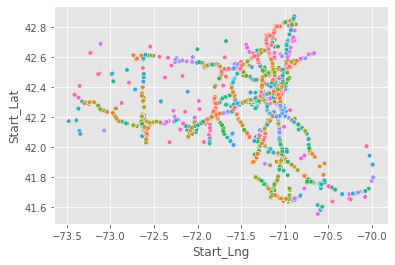

In [18]:
# Map of accidents by city  ## need to run it in colab

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='City', legend=False, s=20)
plt.show()

In [19]:
df_state.describe()

,Severity,Start_Lng,Start_Lat,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Hour,Time_Duration(min)
count,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000
mean,2.367213,-71.290857,42.307674,0.647441,53.658508,65.251475,29.874675,8.631016,12.215574,167.083115
std,0.635022,0.455808,0.248401,1.599184,18.306076,22.089127,0.364568,2.913276,5.362748,267.175631
min,1.000000,-73.476868,41.554653,0.000000,-13.000000,12.000000,28.100000,0.100000,0.000000,12.000000
25%,2.000000,-71.345549,42.178483,0.000000,41.000000,47.000000,29.730000,10.000000,8.000000,29.000000
50%,2.000000,-71.140090,42.332505,0.222000,53.000000,67.000000,29.910000,10.000000,13.000000,75.000000
75%,3.000000,-71.053472,42.479550,0.608000,68.000000,86.000000,30.090000,10.000000,16.000000,360.000000
max,4.000000,-69.984700,42.870290,79.946000,97.000000,100.000000,30.850000,10.500000,23.000000,11642.000000


                    Severity  Start_Lng  Start_Lat  Distance(mi)  \
Severity            1.000000  -0.035484   0.003686     -0.060243   
Start_Lng          -0.035484   1.000000  -0.013729     -0.093990   
Start_Lat           0.003686  -0.013729   1.000000     -0.061394   
Distance(mi)       -0.060243  -0.093990  -0.061394      1.000000   
Temperature(F)      0.052313   0.075168   0.017876     -0.019321   
Humidity(%)        -0.073445  -0.025225  -0.129270      0.020975   
Pressure(in)       -0.056434   0.243511   0.065733     -0.017298   
Visibility(mi)     -0.012499   0.034097   0.025347      0.048535   
Hour                0.154411  -0.028710   0.045002     -0.037228   
Time_Duration(min) -0.058090  -0.015846   0.015656      0.073423   

                    Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
Severity                  0.052313    -0.073445     -0.056434       -0.012499   
Start_Lng                 0.075168    -0.025225      0.243511        0.034097   
Start_La

<AxesSubplot:>

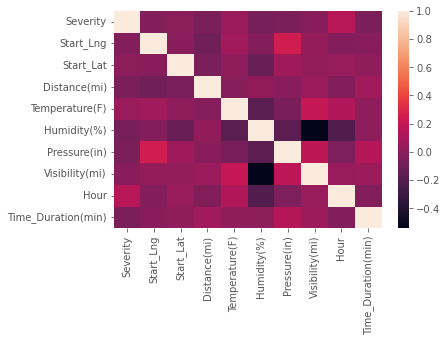

In [20]:
##correaltion and its heatmap
cormat = df_state.corr()
round(cormat,2)
print(cormat)
sns.heatmap(cormat)

### Start_lattiude, distance, temperatute, junction ( should pay attention)

In [21]:
plt.scatterplot(x=df_state['Time_Duration(min)'],y=df_state['Severity'])

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatterplot'

In [22]:
plt.scatterplot(x='Severity',y='Start_Lat', data=df_state, s=20)


AttributeError: module 'matplotlib.pyplot' has no attribute 'scatterplot'

In [23]:
plt.scatterplot(x='Severity',y='Distance(mi)', data=df_state, s=20)

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatterplot'

In [24]:

plt.scatterplot(x='Severity',y='Temperature(F)', data=df_state, s=20)

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatterplot'

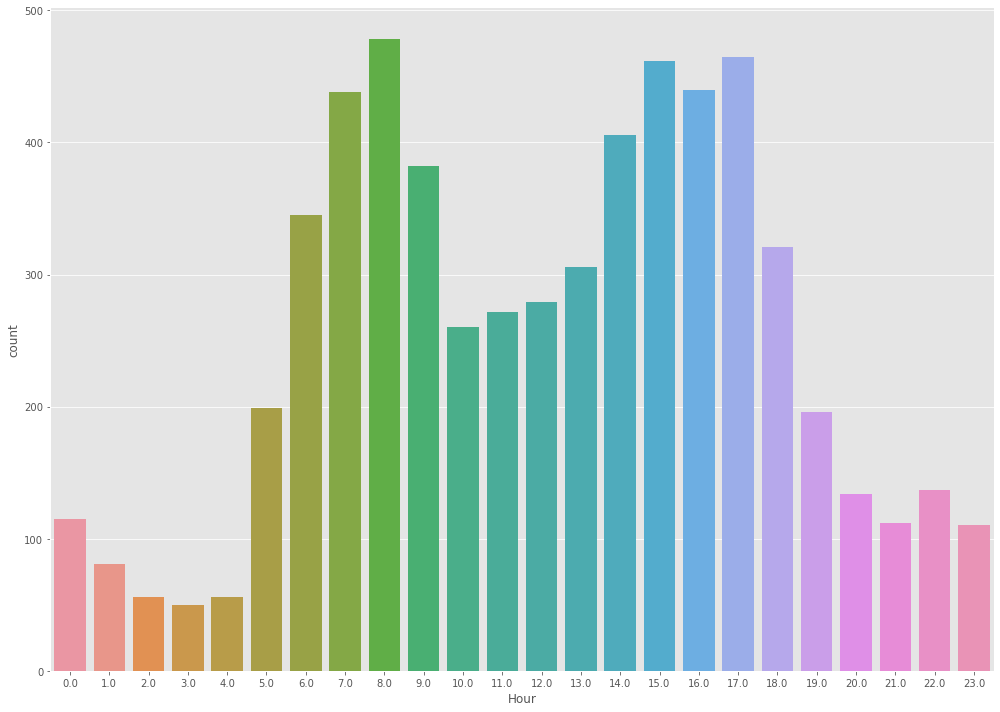

In [25]:

import seaborn as  sns
sns.catplot(x='Hour',data=df_state, kind='count',height=10, aspect=14/10)

# modelling

In [26]:
# create dummies for categorical data before modeeling 
df_state = pd.get_dummies(df_state,drop_first=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100 entries, 31631 to 2844947
Columns: 373 entries, Severity to Weekday_Wed
dtypes: float64(10), uint8(363)
memory usage: 2.7 MB


In [27]:

#  the desired data and features
df=df_state

# Set the target for the prediction ( severit is our target variable)
target='Severity'

# Set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing datasets  80% and 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)


In [28]:
# four classification algorithms we may try to testify to see which one is the best in accuracy
algorithm_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# empty list for the accuracy for each algorithm
accuracy_list=[]


In [29]:
# First one is the Logistic Regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
accuracy=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_list.append(accuracy)

print(accuracy)


0.6901639344262295


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        25
         2.0       0.70      0.95      0.80       801
         3.0       0.63      0.26      0.37       315
         4.0       0.00      0.00      0.00        79

    accuracy                           0.69      1220
   macro avg       0.33      0.30      0.29      1220
weighted avg       0.62      0.69      0.62      1220



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
# Logistic Regression with Grid Search CV

In [41]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [42]:
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [43]:
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [44]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.7194672131147541


use best parameter to fit the model 

In [45]:
logreg = LogisticRegression(C = 0.1, 
                            penalty = 'l2', 
                            solver = 'newton-cg')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

Accuracy: 0.7106557377049181


Increase 2 % after gridsearch 

# KNN 

In [31]:
# KNN, start with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
accuracy=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_list.append(accuracy)

print(accuracy)



0.7188524590163935


In [32]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.39      0.28      0.33        25
         2.0       0.75      0.90      0.82       801
         3.0       0.64      0.44      0.52       315
         4.0       0.45      0.16      0.24        79

    accuracy                           0.72      1220
   macro avg       0.56      0.45      0.48      1220
weighted avg       0.70      0.72      0.69      1220



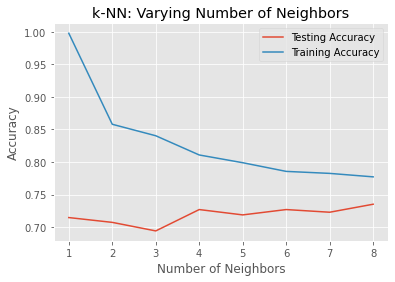

In [33]:
## turning the n-neigbour to find the best k 
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a KNN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


In [34]:
#  8 neighbors KNN
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
accuracy=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_list.append(accuracy)

print(accuracy)


0.7352459016393442


In [35]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.47      0.32      0.38        25
         2.0       0.75      0.93      0.83       801
         3.0       0.69      0.44      0.54       315
         4.0       0.43      0.08      0.13        79

    accuracy                           0.74      1220
   macro avg       0.59      0.44      0.47      1220
weighted avg       0.71      0.74      0.70      1220



# Decision Tree

In [36]:
#  Decision Tree
# method 1 'entropy'
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print(accuracy_entropy)



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy=accuracy_gini
accuracy_list.append(accuracy)

# Print accuracy_gini
print(accuracy_gini)


0.7598360655737705
0.7442622950819672


In [37]:
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

         1.0       0.64      0.36      0.46        25
         2.0       0.76      0.92      0.83       801
         3.0       0.67      0.49      0.57       315
         4.0       0.90      0.11      0.20        79

    accuracy                           0.74      1220
   macro avg       0.74      0.47      0.52      1220
weighted avg       0.74      0.74      0.72      1220



# Random Forest 

In [47]:
#  Random Forest
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=500)

rf.fit(X_train,y_train)

## predict 
y_pred=rf.predict(X_test)


#  accuracy score
accuracy=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_list.append(accuracy)
print(accuracy)


print('Parameters currently in use:\n')
print(rf.get_params())


0.8147540983606557
Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [39]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       1.00      0.36      0.53        25
         2.0       0.80      0.96      0.87       801
         3.0       0.83      0.58      0.69       315
         4.0       0.88      0.38      0.53        79

    accuracy                           0.81      1220
   macro avg       0.88      0.57      0.66      1220
weighted avg       0.82      0.81      0.80      1220



# Random search parameter for random Forest

In [109]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [110]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [114]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [115]:
best_model = RandomForestClassifier(n_estimators= 1000,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'auto',
 max_depth= 50,
 bootstrap= False)
best_model.fit(X_train,y_train)

y_pred=best_model.predict(X_test)

#  accuracy score
accuracy=accuracy_score(y_test, y_pred)
accuracy

0.8254098360655737

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.92      0.44      0.59        25
         2.0       0.81      0.96      0.88       801
         3.0       0.86      0.60      0.71       315
         4.0       0.83      0.44      0.58        79

    accuracy                           0.82      1220
   macro avg       0.86      0.61      0.69      1220
weighted avg       0.83      0.82      0.81      1220



feature importance 

In [120]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (50,50)
plt.style.use("ggplot")

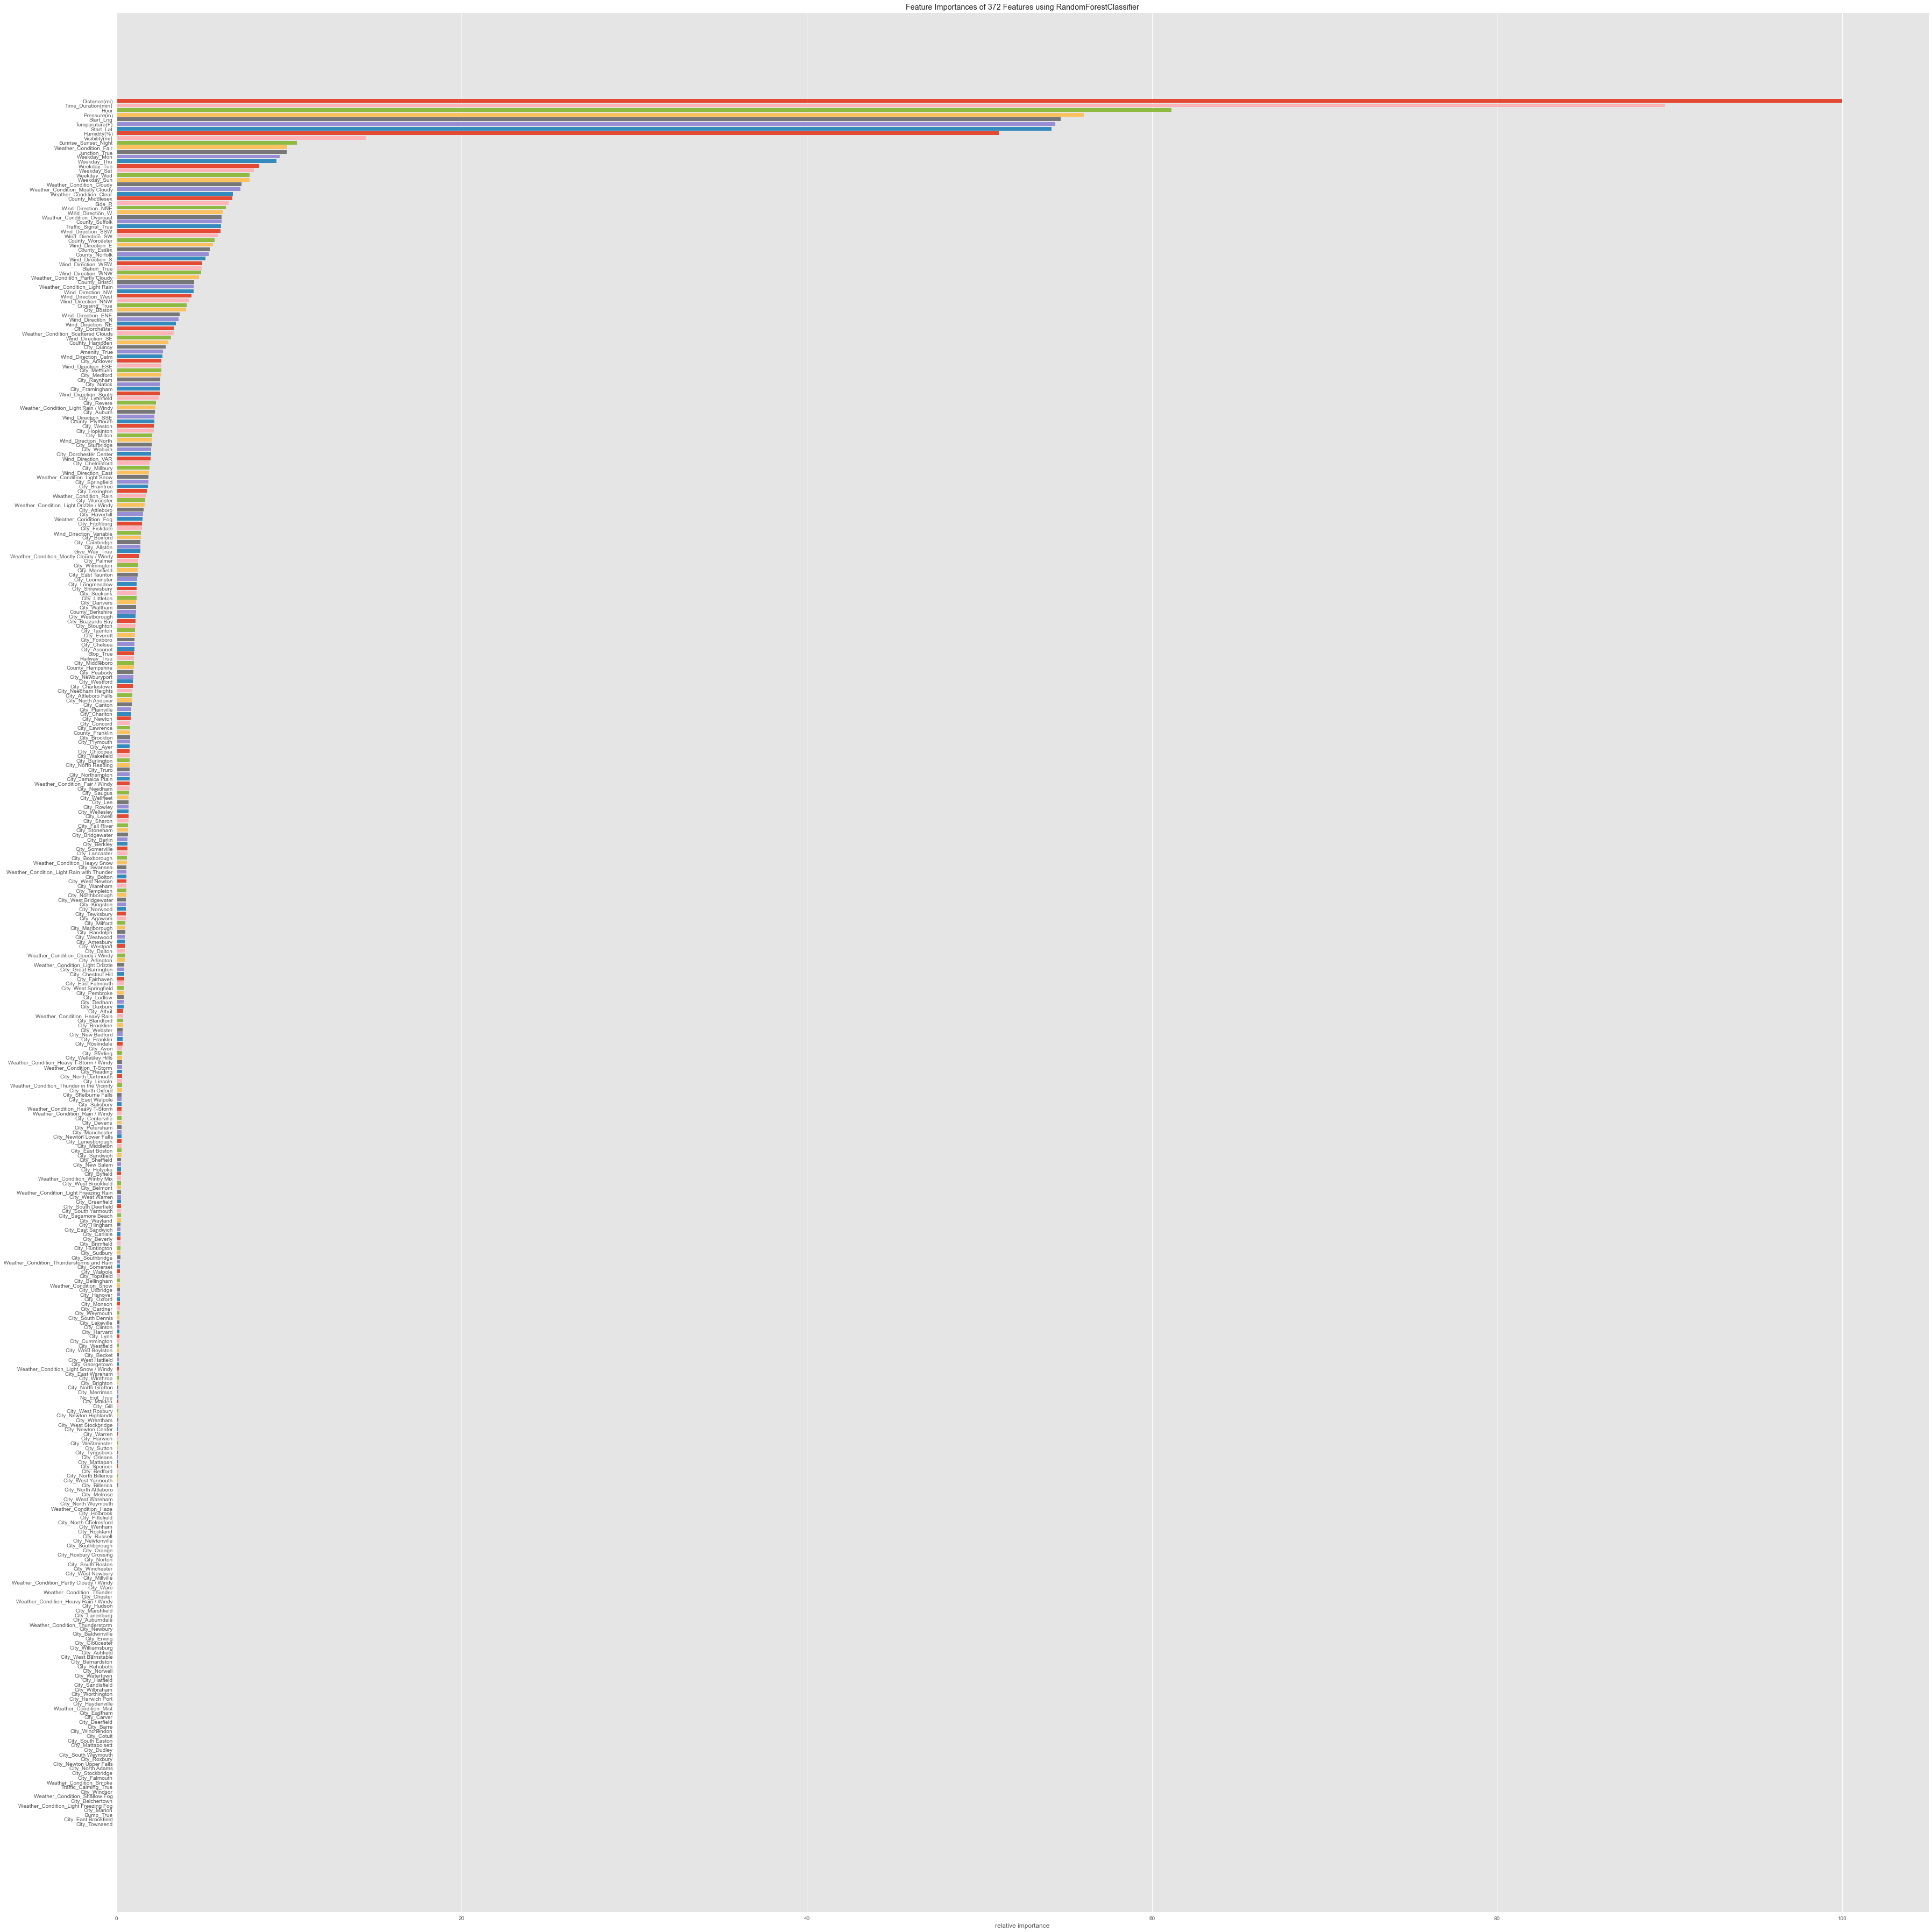

<AxesSubplot:title={'center':'Feature Importances of 372 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [121]:
viz=FeatureImportances(clf)
viz.fit(X_train,y_train)
viz.show()

No handles with labels found to put in legend.


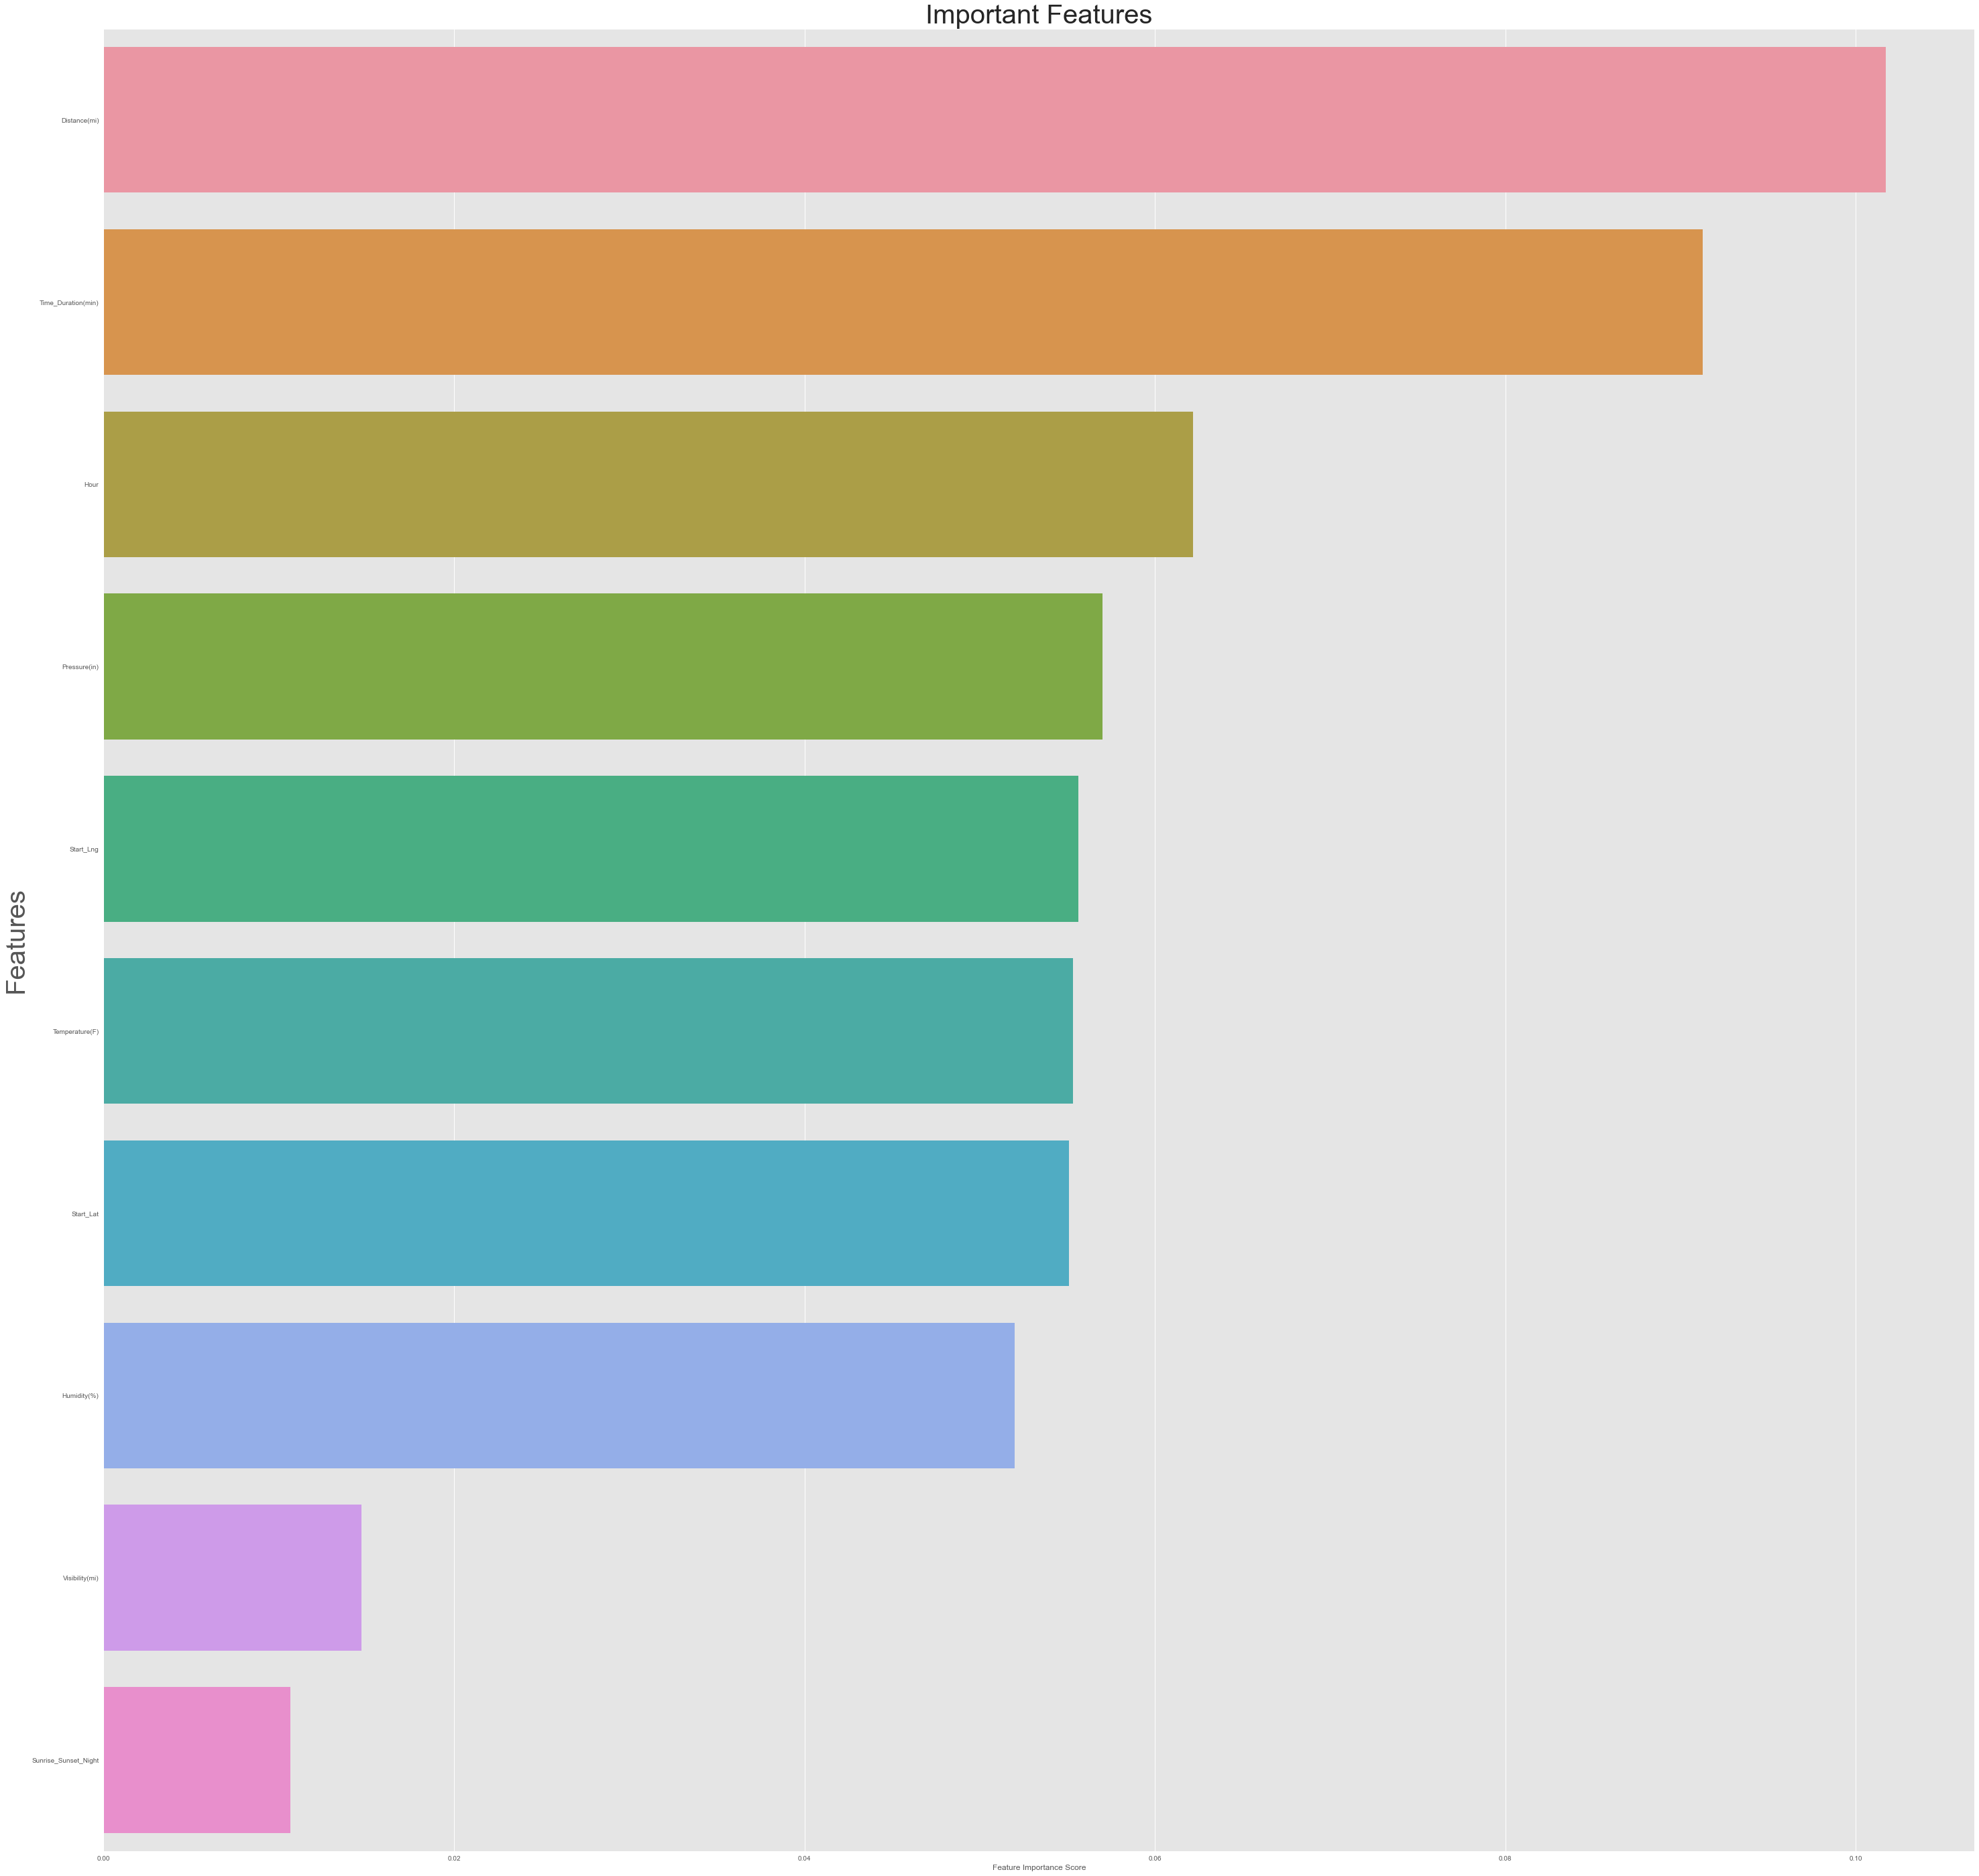

In [127]:
# Visualize the features
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features',fontsize=40)
plt.title("Important Features",fontsize=40)
plt.legend()
plt.show()

In [128]:
# List top k important features
k=15
feature_imp.sort_values(ascending=False)[:k]

Distance(mi)              0.101692
Time_Duration(min)        0.091271
Hour                      0.062158
Pressure(in)              0.056988
Start_Lng                 0.055632
Temperature(F)            0.055319
Start_Lat                 0.055091
Humidity(%)               0.052004
Visibility(mi)            0.014703
Sunrise_Sunset_Night      0.010642
Weather_Condition_Fair    0.010036
Junction_True             0.010035
Weekday_Mon               0.009604
Weekday_Thu               0.009427
Weekday_Tue               0.008404
dtype: float64

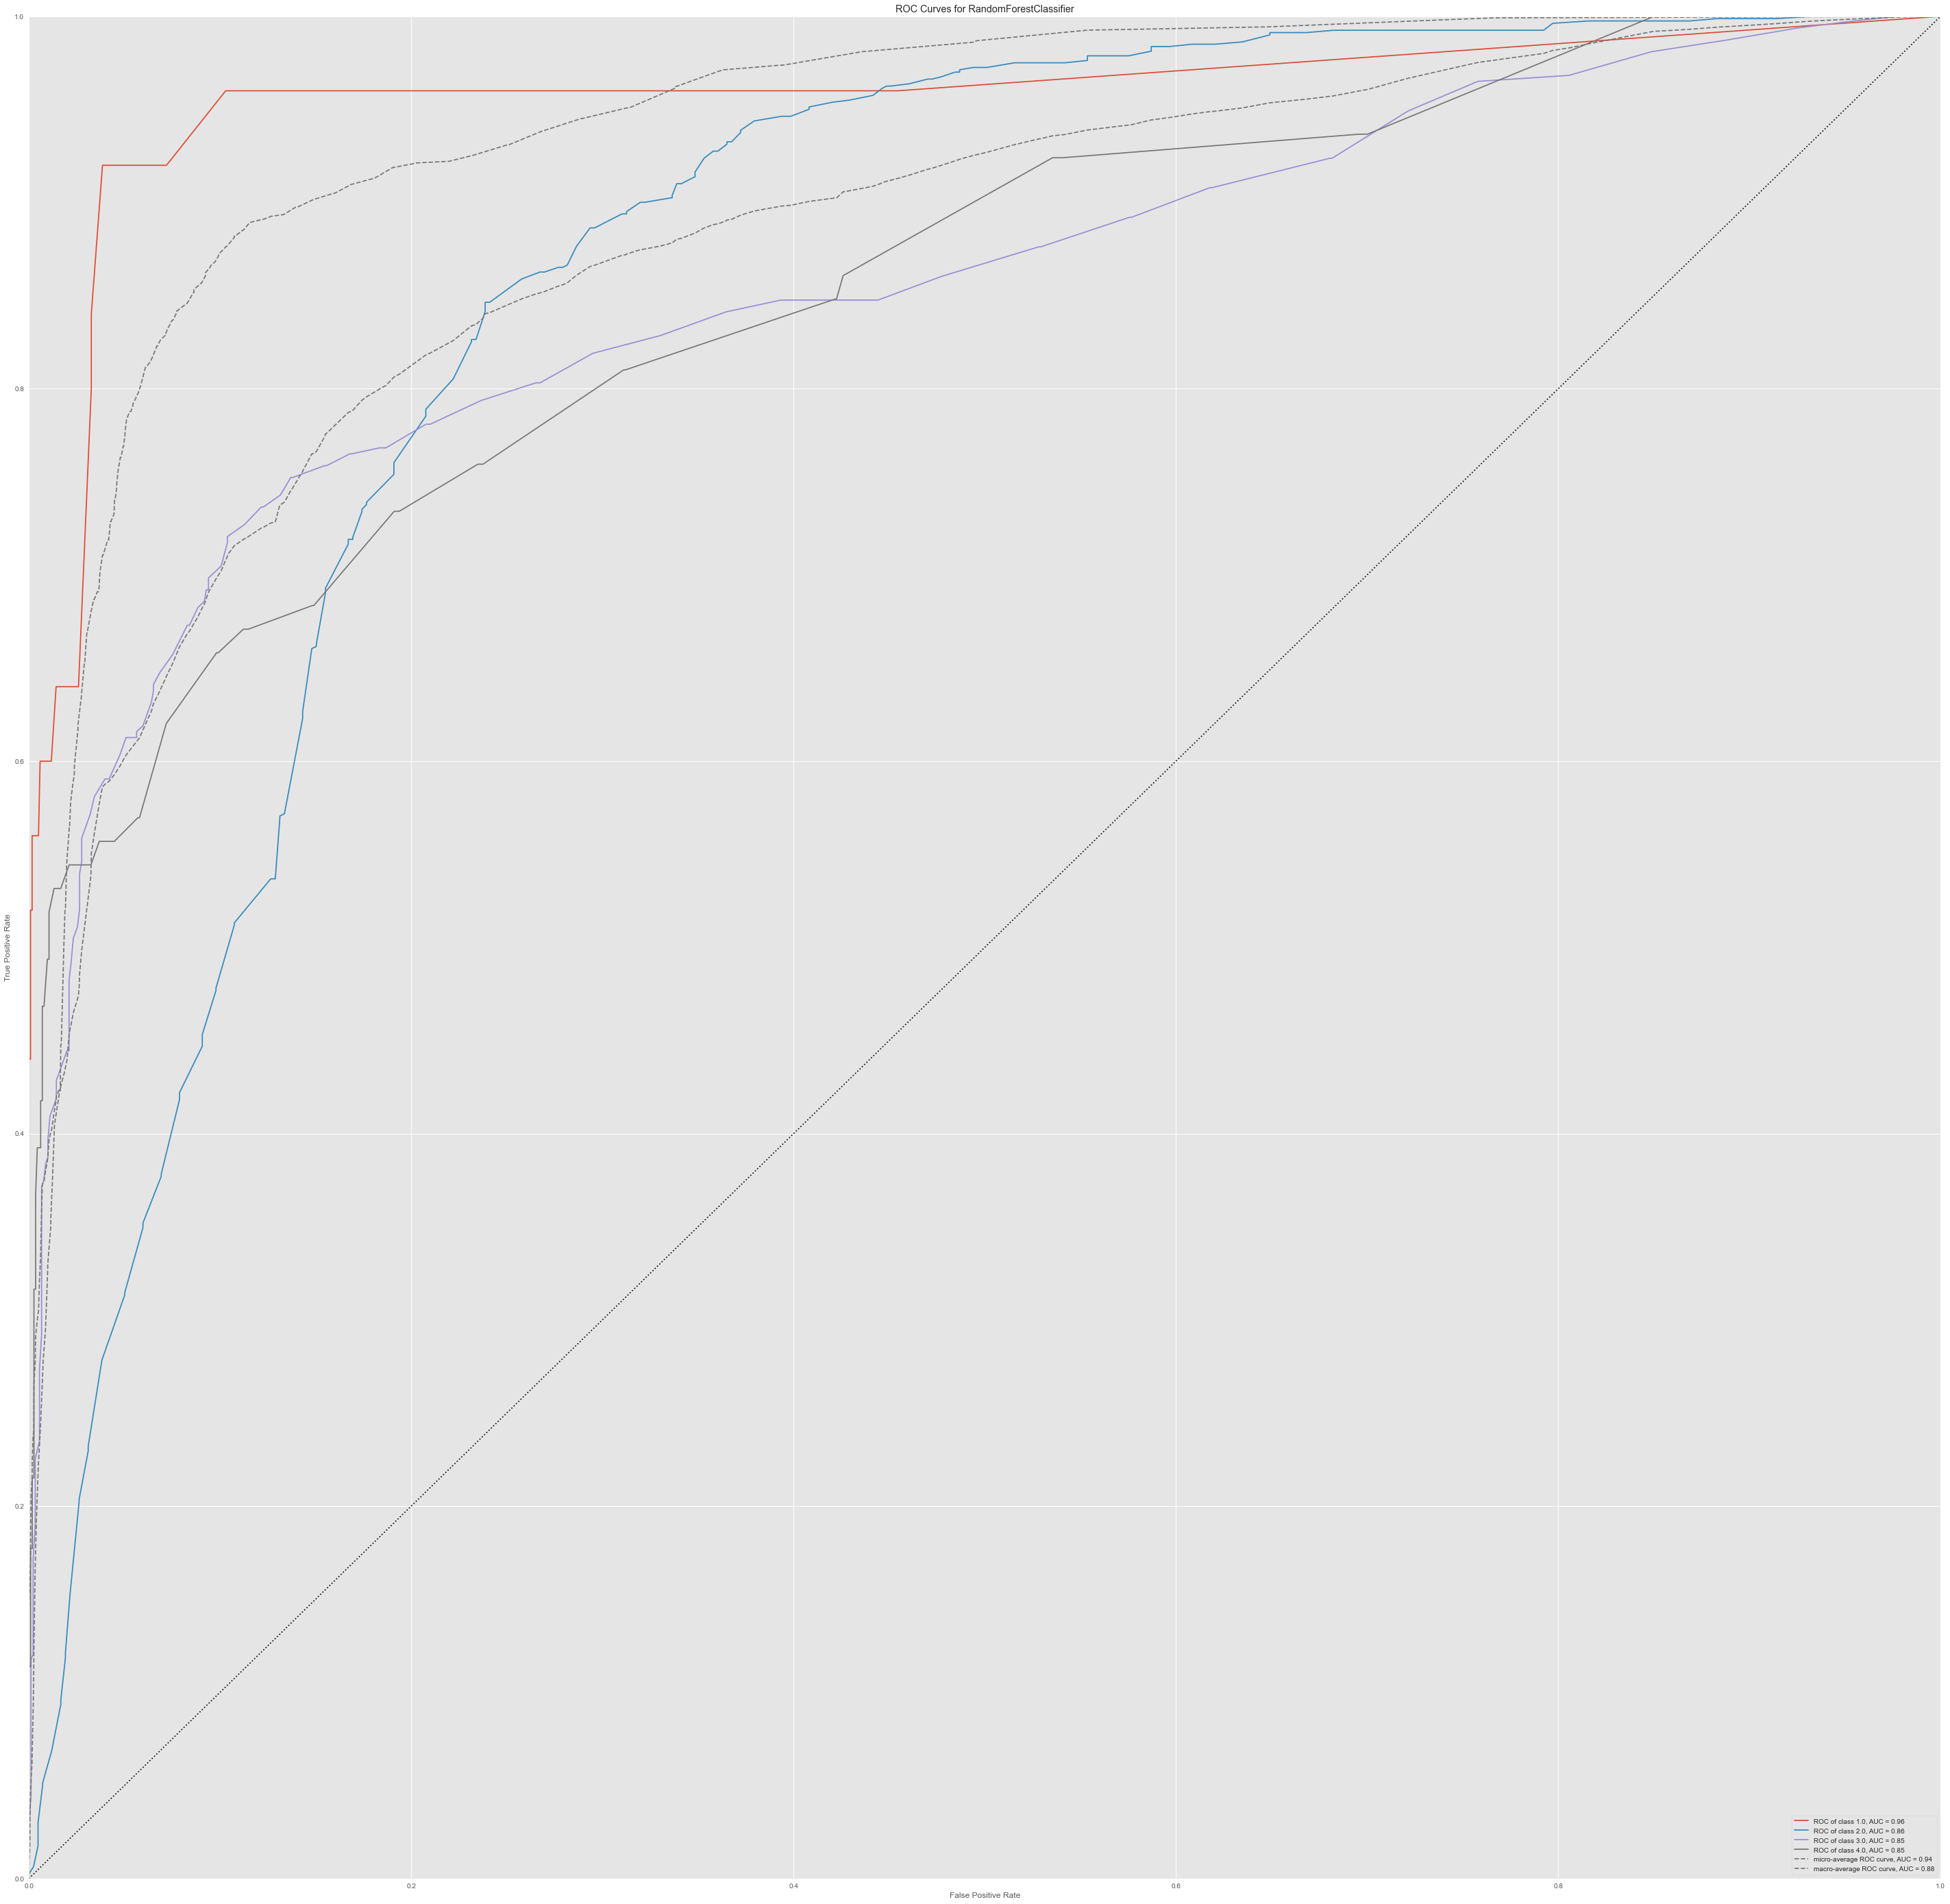

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [123]:
from yellowbrick.classifier import ROCAUC

visualizer=ROCAUC(clf)
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof()


distance , time duration, hour, pressure are the top 4 feature 

Grid search 

In [60]:
# param_grid:
param_grid = {
'n_estimators': [50, 100, 200, 300,500,800,1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [2, 4, 6, 8, 10],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}
# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=clf,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=5,
refit=True,
return_train_score=True)

In [65]:

# Fit the selected model
model_gridsearch.fit(X_train, y_train)
# Print the time spend and number of models ran


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 500, 800, 1000]},
             return_train_score=True, scoring='accuracy')

In [66]:
y_pred_grid = model_gridsearch.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
accuracy_grid

0.739344262295082

# Adaboost

In [70]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]


In [71]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

In [72]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.735587 using {'learning_rate': 0.01, 'n_estimators': 500}
0.704235 (0.019877) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.704235 (0.019877) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.704235 (0.019877) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.704235 (0.019877) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.704235 (0.019877) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.704235 (0.019877) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.704235 (0.019877) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.706079 (0.021267) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.704235 (0.019877) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.710861 (0.022193) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.719194 (0.015974) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.735587 (0.013296) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.719877 (0.014807) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.73435

# XG boost 

In [87]:
pip install hyperopt

     |████████████████████████████████| 1.6 MB 1.5 MB/s            
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [88]:
# Dataset
from sklearn import datasets
# Data processing
import pandas as pd
import numpy as np
# Standardize the data
from sklearn.preprocessing import StandardScaler
# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [89]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier()
# Print default setting
xgboost.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [91]:
# Train the model
xgboost = XGBClassifier(seed=0).fit(X_train,y_train)
# Make prediction
xgboost_predict = xgboost.predict(X_test)
# Get predicted probability
xgboost_predict = xgboost.predict(X_test)

[22:28:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
# Get performance metrics
precision, recall, fscore, support = score(y_test, xgboost_predict)
# Print result
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')

The recall value for the baseline xgboost model is 0.9288


In [99]:
fscore

array([0.51428571, 0.87081892, 0.68222621, 0.52631579])

In [93]:
accuracy = accuracy_score(y_test, xgboost_predict)
accuracy

0.8057377049180328

# grid_searchcv

In [95]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [96]:
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)
# Print grid search summary
grid_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[22:59:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best score is nan
The best score standard deviation is nan
The best hyperparameters are {'colsample_bytree': 0.3, 'reg_alpha': 0, 'reg_lambda': 0}


In [97]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)
# Get performance metrics
precision, recall, fscore, support = score(y_test, grid_predict)
# Print result
print(f'The recall value for the xgboost grid search is {recall[1]:.4f}')

The recall value for the xgboost grid search is 0.9426


In [100]:
accuracy = accuracy_score(y_test, grid_predict)
accuracy

0.8065573770491803

In [ ]:
## the other way


# Random search

In [103]:
# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['roc_auc']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [104]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgboost, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
random_result = random_search.fit(X_train, y_train)
# Print grid search summary
random_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[23:58:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best score is nan


KeyError: 'std_test_recall'

In [107]:
print(f'The best hyperparameters are {random_result.best_params_}')

# Make prediction using the best model
random_predict = random_search.predict(X_test)
# Get predicted probabilities
# Get performance metrics
precision, recall, fscore, support = score(y_test, random_predict)
# Print result
print(f'The recall value for the xgboost random search is {recall[1]:.4f}')

The best hyperparameters are {'reg_lambda': 1e-05, 'reg_alpha': 0.01, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.6}
The recall value for the xgboost random search is 0.9376


In [108]:
accuracy = accuracy_score(y_test, random_predict)
accuracy

0.7221311475409836

[23:41:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol